In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
from csv import writer
import math
import cmath
import pickle

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

In [5]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)

[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


In [6]:
from sklearn.preprocessing import MinMaxScaler
import warnings
scaler_obj=MinMaxScaler()
X1=scaler_obj.fit_transform(A1)
Y1=scaler_obj.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [7]:
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [8]:
model = Sequential()
model.add(keras.Input(shape=(1,5)))
model.add(tf.keras.layers.GRU(14,activation="tanh",use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="zeros", 
                                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=keras.regularizers.l2(1e-4),
                                activity_regularizer=keras.regularizers.l2(1e-5)))
model.add(keras.layers.Dropout(.1))
model.add(Dense(7))
model.add(keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,
                                beta_initializer="zeros",gamma_initializer="ones",
                                moving_mean_initializer="zeros",moving_variance_initializer="ones",trainable=True))
model.add(keras.layers.ReLU())
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='binary_crossentropy',metrics=['accuracy','mse','mae',rmse])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14)                882       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 7)                 105       
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 7)                 0         
                                                                 
Total params: 1,015
Trainable params: 1,001
Non-trainable params: 14
_____________________________________________________

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

history2 = model.fit(x_train,y_train,batch_size=256,epochs=50, validation_split=0.1)

Epoch 1/50
4563/4563 [==============================] - 62s 12ms/step - loss: 2.2061 - accuracy: 0.1817 - mse: 0.3700 - mae: 0.3262 - rmse: 0.4910 - val_loss: 1.4632 - val_accuracy: 0.1774 - val_mse: 0.2475 - val_mae: 0.2192 - val_rmse: 0.3209
Epoch 2/50
4563/4563 [==============================] - 54s 12ms/step - loss: 2.1428 - accuracy: 0.1818 - mse: 0.3581 - mae: 0.3168 - rmse: 0.4802 - val_loss: 1.4488 - val_accuracy: 0.1774 - val_mse: 0.2427 - val_mae: 0.2106 - val_rmse: 0.3130
Epoch 3/50
4563/4563 [==============================] - 56s 12ms/step - loss: 2.0785 - accuracy: 0.1818 - mse: 0.3450 - mae: 0.3063 - rmse: 0.4677 - val_loss: 1.4417 - val_accuracy: 0.1774 - val_mse: 0.2377 - val_mae: 0.2048 - val_rmse: 0.3093
Epoch 4/50
4563/4563 [==============================] - 56s 12ms/step - loss: 1.9916 - accuracy: 0.1819 - mse: 0.3291 - mae: 0.2936 - rmse: 0.4511 - val_loss: 1.4342 - val_accuracy: 0.1774 - val_mse: 0.2331 - val_mae: 0.1984 - val_rmse: 0.3010
Epoch 5/50
4563/4563 [==

4563/4563 [==============================] - 54s 12ms/step - loss: 0.5473 - accuracy: 0.3181 - mse: 0.0513 - mae: 0.0570 - rmse: 0.1284 - val_loss: 0.5804 - val_accuracy: 0.1773 - val_mse: 0.0477 - val_mae: 0.0483 - val_rmse: 0.1165
Epoch 35/50
4563/4563 [==============================] - 55s 12ms/step - loss: 0.5439 - accuracy: 0.3227 - mse: 0.0497 - mae: 0.0557 - rmse: 0.1258 - val_loss: 0.5804 - val_accuracy: 0.1773 - val_mse: 0.0467 - val_mae: 0.0479 - val_rmse: 0.1155
Epoch 36/50
4563/4563 [==============================] - 55s 12ms/step - loss: 0.5419 - accuracy: 0.3251 - mse: 0.0490 - mae: 0.0551 - rmse: 0.1246 - val_loss: 0.5804 - val_accuracy: 0.1774 - val_mse: 0.0458 - val_mae: 0.0476 - val_rmse: 0.1146
Epoch 37/50
4563/4563 [==============================] - 54s 12ms/step - loss: 0.5301 - accuracy: 0.3283 - mse: 0.0459 - mae: 0.0537 - rmse: 0.1210 - val_loss: 0.5804 - val_accuracy: 0.1774 - val_mse: 0.0416 - val_mae: 0.0459 - val_rmse: 0.1102
Epoch 38/50
4563/4563 [=========

In [13]:
model.evaluate(x_test,y_test)

13518/13518 [==============================] - 72s 5ms/step - loss: 0.1207 - accuracy: 0.9268 - mse: 4.8948e-04 - mae: 0.0110 - rmse: 0.0194


[0.12074405699968338,
 0.9268213510513306,
 0.0004894836456514895,
 0.010985419154167175,
 0.019426381215453148]

In [14]:
model.evaluate(x_train,y_train)

40554/40554 [==============================] - 227s 6ms/step - loss: 0.1205 - accuracy: 0.9274 - mse: 4.8750e-04 - mae: 0.0110 - rmse: 0.0194


[0.12045808136463165,
 0.9274206161499023,
 0.0004874956503044814,
 0.010966532863676548,
 0.019401833415031433]

In [36]:
model_json = model.to_json()
with open("Model_File/gru_tanh_binary.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Model_File/gru_tanh_binary.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('Model_File/gru_tanh_binary.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Model_File/gru_tanh_binary.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='binary_crossentropy',metrics=['accuracy','mse','mae',rmse])

Loaded model from disk


In [20]:
loaded_model.evaluate(x_test,y_test)

13518/13518 [==============================] - 70s 5ms/step - loss: 0.1207 - accuracy: 0.9268 - mse: 4.8948e-04 - mae: 0.0110 - rmse: 0.0194


[0.12074405699968338,
 0.9268213510513306,
 0.0004894836456514895,
 0.010985419154167175,
 0.019426381215453148]

In [21]:
loaded_model.evaluate(x_train,y_train)

40554/40554 [==============================] - 226s 6ms/step - loss: 0.1205 - accuracy: 0.9274 - mse: 4.8750e-04 - mae: 0.0110 - rmse: 0.0194


[0.12045808136463165,
 0.9274206161499023,
 0.0004874956503044814,
 0.010966532863676548,
 0.019401833415031433]

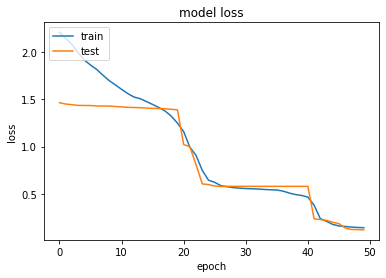

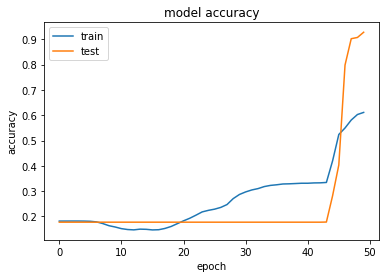

In [27]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=model.predict(x_test)
y_test_pred

array([[0.        , 0.11451954, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04681784, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01952261, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00879645, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.12825912, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01913267, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [31]:
y_test

array([[[0.00011559, 0.06553685, 0.00011085, ..., 0.0021448 ,
         0.0014142 , 0.00052142]],

       [[0.00011088, 0.06553695, 0.00012144, ..., 0.01090628,
         0.00639894, 0.00234271]],

       [[0.0001138 , 0.06553686, 0.00011756, ..., 0.02938369,
         0.01855402, 0.00761428]],

       ...,

       [[0.00011103, 0.06553663, 0.00011547, ..., 0.05674056,
         0.03595096, 0.01243099]],

       [[0.00011477, 0.06553688, 0.00010965, ..., 0.00815022,
         0.00468672, 0.00148292]],

       [[0.00010879, 0.06553657, 0.00012025, ..., 0.00375339,
         0.00246608, 0.00081172]]], dtype=float32)

In [32]:
y_test=y_test[:,0]
# y_test_pred=y_test_pred[:,0]

In [33]:
from numpy import savetxt
savetxt('ARRAY_DATA/gru_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [34]:
from numpy import savetxt
savetxt('ARRAY_DATA/gru_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed